In [60]:
# %load nbheader.py
%reload_ext autoreload
%autoreload 2
%reload_ext sql

import os
jp = os.path.join
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa

# edit the list of directories where to search for the `myolyn_tools` package
for sd in reversed(['/data/project/shepherd_myolyn/src']):
    if not sd in sys.path:
        sys.path.insert(0, sd)
           
from myolyn_tools import *


### This statement must be exectuted once at the start of the notebook,
### and everytime the notebook kernel is restarted.
engine = sa.create_engine(postgresql_connection_uri(), echo=False)

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [62]:
load_summary_data = """
SELECT *
FROM public_v1.summary
"""

summary_df = pd.read_sql(sa.text(load_summary_data), con=engine)

In [63]:
# Split the summary_df into two DFs based on the device type
summary_df_v1 = summary_df[summary_df['device'] == 'MC-HP-1'].copy()
summary_df_v2 = summary_df[summary_df['device'] == 'MP-2'].copy()

# Convert 'device' column to numerical values
summary_df_v1['device'] = summary_df_v1['device'].replace({'MC-HP-1': '1'})
summary_df_v2['device'] = summary_df_v2['device'].replace({'MP-2': '2'})

In [64]:
# Engineered Features for device-1:

# 1. Workout Total Duration for v1: Calculate total workout duration per user
total_duration_v1 = summary_df_v1.groupby('user_id')['duration_min'].sum().reset_index()
total_duration_v1.columns = ['user_id', 'total_workout_duration']

# 2. Total workouts per user for v1
total_workouts_per_user_v1 = summary_df_v1.groupby('user_id').size().reset_index(name='total_workouts')

# 3. Consistency: Measure the regularity of workouts by calculating the standard deviation of the days between workouts
# Calculate the difference in days between workouts for v1
summary_df_v1['days_between'] = summary_df_v1.groupby('user_id')['date_time'].diff().dt.days
# Calculate standard deviation of days between workouts per user
consistency_v1 = summary_df_v1.groupby('user_id')['days_between'].std().reset_index()
consistency_v1.columns = ['user_id', 'workout_consistency_sd']

# 4. Sustained Engagement: Calculate the time span from the first to the last workout for each user
engagement_span_v1 = summary_df_v1.groupby('user_id').agg({'date_time': [min, max]}).reset_index()
engagement_span_v1.columns = ['user_id', 'first_workout', 'last_workout']
engagement_span_v1['sustained_engagement'] = (engagement_span_v1['last_workout'] - engagement_span_v1['first_workout']).dt.days

# 5. Workout duration consistency (can be seen as Fatigue): Calculate standard deviation of duration_min for each user_id
# High SD means the duration varies a lot for the user_id and Low SD means the user is pretty consistent in the workout duration
duration_min_sd_v1 = summary_df_v1.groupby('user_id')['duration_min'].std().reset_index()
# Rename the column for clarity
duration_min_sd_v1.rename(columns={'duration_min': 'duration_min_sd'}, inplace=True)

# Merge the engineered features
longevity_metrics_v1 = total_duration_v1.merge(total_workouts_per_user_v1, on='user_id')  \
                             .merge(consistency_v1, on='user_id')  \
                             .merge(engagement_span_v1[['user_id', 'sustained_engagement']], on='user_id')  \
                             .merge(duration_min_sd_v1, on='user_id')


In [65]:
# Engineered Features:

# 1. Workout Total Duration for v2: Calculate total workout duration per user
total_duration_v2 = summary_df_v2.groupby('user_id')['duration_min'].sum().reset_index()
total_duration_v2.columns = ['user_id', 'total_workout_duration']

# 2. Total workouts per user for v2
total_workouts_per_user_v2 = summary_df_v2.groupby('user_id').size().reset_index(name='total_workouts')

# 3. Consistency: Measure the regularity of workouts by calculating the standard deviation of the days between workouts
# Calculate the difference in days between workouts for v2
summary_df_v2['days_between'] = summary_df_v2.groupby('user_id')['date_time'].diff().dt.days
# Calculate standard deviation of days between workouts per user
consistency_v2 = summary_df_v2.groupby('user_id')['days_between'].std().reset_index()
consistency_v2.columns = ['user_id', 'workout_consistency_sd']

# 4. Sustained Engagement: Calculate the time span from the first to the last workout for each user
engagement_span_v2 = summary_df_v2.groupby('user_id').agg({'date_time': [min, max]}).reset_index()
engagement_span_v2.columns = ['user_id', 'first_workout', 'last_workout']
engagement_span_v2['sustained_engagement'] = (engagement_span_v2['last_workout'] - engagement_span_v2['first_workout']).dt.days

# 5. Workout duration consistency (can be seen as Fatigue): Calculate standard deviation of duration_min for each user_id
# High SD means the duration varies a lot for the user_id and Low SD means the user is pretty consistent in the workout duration
duration_min_sd_v2 = summary_df_v2.groupby('user_id')['duration_min'].std().reset_index()
# Rename the column for clarity
duration_min_sd_v2.rename(columns={'duration_min': 'duration_min_sd'}, inplace=True)

# Merge the engineered features
longevity_metrics_v2 = total_duration_v2.merge(total_workouts_per_user_v2, on='user_id')  \
                             .merge(consistency_v2, on='user_id')  \
                             .merge(engagement_span_v2[['user_id', 'sustained_engagement']], on='user_id')  \
                             .merge(duration_min_sd_v2, on='user_id')



In [66]:
# Check if there are any common user_id using both devices:

common_user_ids = pd.merge(longevity_metrics_v1, longevity_metrics_v2, on='user_id', how='inner')['user_id']

# Print the common user_ids
print(common_user_ids)

0    1702320636
1    1702934274
2    1703089447
Name: user_id, dtype: int64


In [67]:
# Remove the rows with the specified user_id values from both DataFrames
# We don't want to have users using both devices, instead looking at users using device-1 separately and device-2 separately

longevity_metrics_v1 = longevity_metrics_v1[~longevity_metrics_v1['user_id'].isin(common_user_ids)]
longevity_metrics_v2 = longevity_metrics_v2[~longevity_metrics_v2['user_id'].isin(common_user_ids)]

In [68]:
print(longevity_metrics_v1)

       user_id  total_workout_duration  total_workouts  \
0   1702319475                    61.0               2   
2   1702329495                 38179.0             650   
3   1702333022                 18914.0             423   
4   1702333567                 39078.0             694   
5   1702336416                 10536.0             206   
..         ...                     ...             ...   
72  1703093176                   123.0              10   
73  1703093190                    99.0               8   
74  1703093228                    72.0               3   
75  1703093364                    15.0               1   
76  1703107708                133057.0            2443   

    workout_consistency_sd  sustained_engagement  duration_min_sd  
0                      NaN                    32         2.121320  
2                 1.467317                  1469         5.999488  
3                 1.969172                   793        12.833272  
4                 3.170901     

In [69]:
print(longevity_metrics_v2)

       user_id  total_workout_duration  total_workouts  \
1   1702328605                  3766.0              73   
2   1702328673                   701.0              28   
3   1702330543                 24312.0             432   
4   1702336541                  4545.0              78   
5   1702490971                  1700.0              62   
6   1702491462                  5161.0             103   
7   1702491522                  2269.0              54   
8   1702924337                  5754.0             123   
10  1702934484                  1844.0              46   
11  1703008601                   483.0              19   
12  1703008618                  1182.0              40   
13  1703008658                  1890.0              32   
14  1703008716                   623.0              17   
15  1703008811                   754.0              25   
16  1703008860                  2089.0              84   
17  1703009229                  1005.0              35   
18  1703009255

In [70]:
# Check for NaN values in longevity_metrics_v1
nan_values_v1 = longevity_metrics_v1.isnull().sum()
print("NaN values in longevity_metrics_v1:")
print(nan_values_v1)

# Check for NaN values in longevity_metrics_v2
nan_values_v2 = longevity_metrics_v2.isnull().sum()
print("NaN values in longevity_metrics_v2:")
print(nan_values_v2)

NaN values in longevity_metrics_v1:
user_id                   0
total_workout_duration    0
total_workouts            0
workout_consistency_sd    3
sustained_engagement      0
duration_min_sd           2
dtype: int64
NaN values in longevity_metrics_v2:
user_id                   0
total_workout_duration    0
total_workouts            0
workout_consistency_sd    0
sustained_engagement      0
duration_min_sd           0
dtype: int64


In [71]:
# Drop rows with NaN values in any column in longevity_metrics_v1
longevity_metrics_v1 = longevity_metrics_v1.dropna()

# Drop rows with NaN values in any column in longevity_metrics_v2
longevity_metrics_v2 = longevity_metrics_v2.dropna()

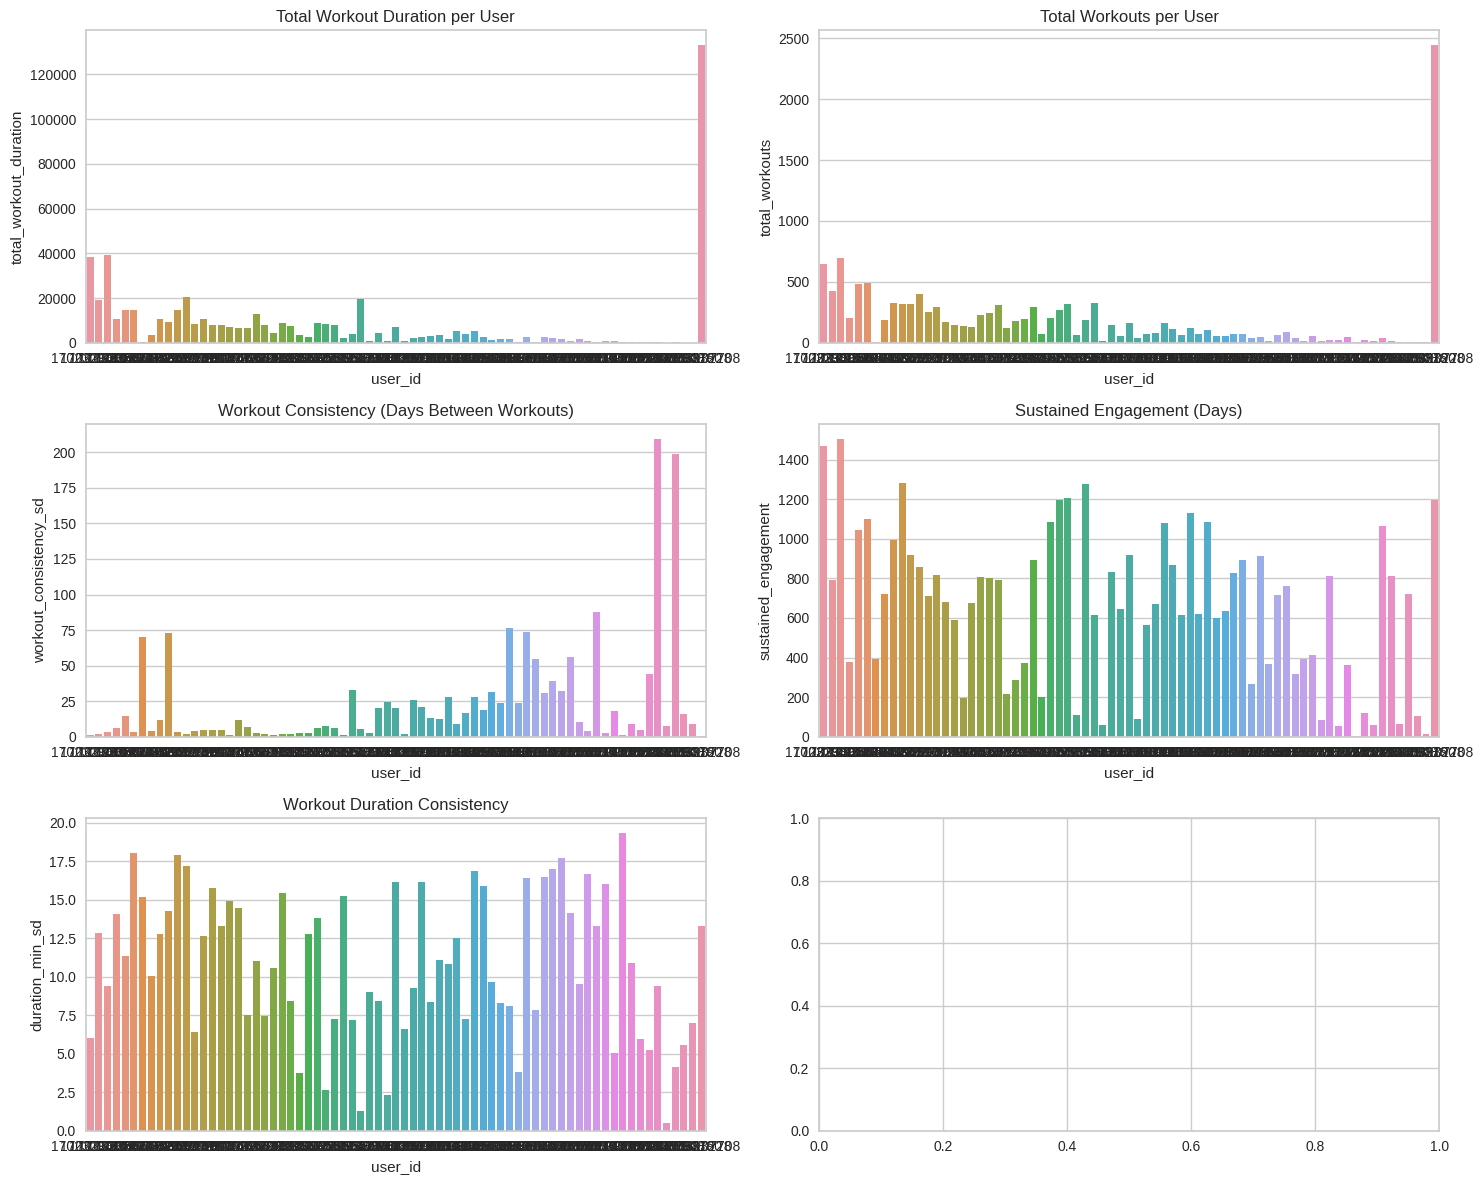

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up subplots for each feature
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Total Workout Duration
sns.barplot(x='user_id', y='total_workout_duration', data=longevity_metrics_v1, ax=axes[0, 0])
axes[0, 0].set_title('Total Workout Duration per User')

# Total Workouts
sns.barplot(x='user_id', y='total_workouts', data=longevity_metrics_v1, ax=axes[0, 1])
axes[0, 1].set_title('Total Workouts per User')

# Workout Consistency (Standard Deviation of Days Between Workouts)
sns.barplot(x='user_id', y='workout_consistency_sd', data=longevity_metrics_v1, ax=axes[1, 0])
axes[1, 0].set_title('Workout Consistency (Days Between Workouts)')

# Sustained Engagement (Time Span from First to Last Workout)
sns.barplot(x='user_id', y='sustained_engagement', data=longevity_metrics_v1, ax=axes[1, 1])
axes[1, 1].set_title('Sustained Engagement (Days)')

# Workout Duration Consistency (Standard Deviation of duration_min)
sns.barplot(x='user_id', y='duration_min_sd', data=longevity_metrics_v1, ax=axes[2, 0])
axes[2, 0].set_title('Workout Duration Consistency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


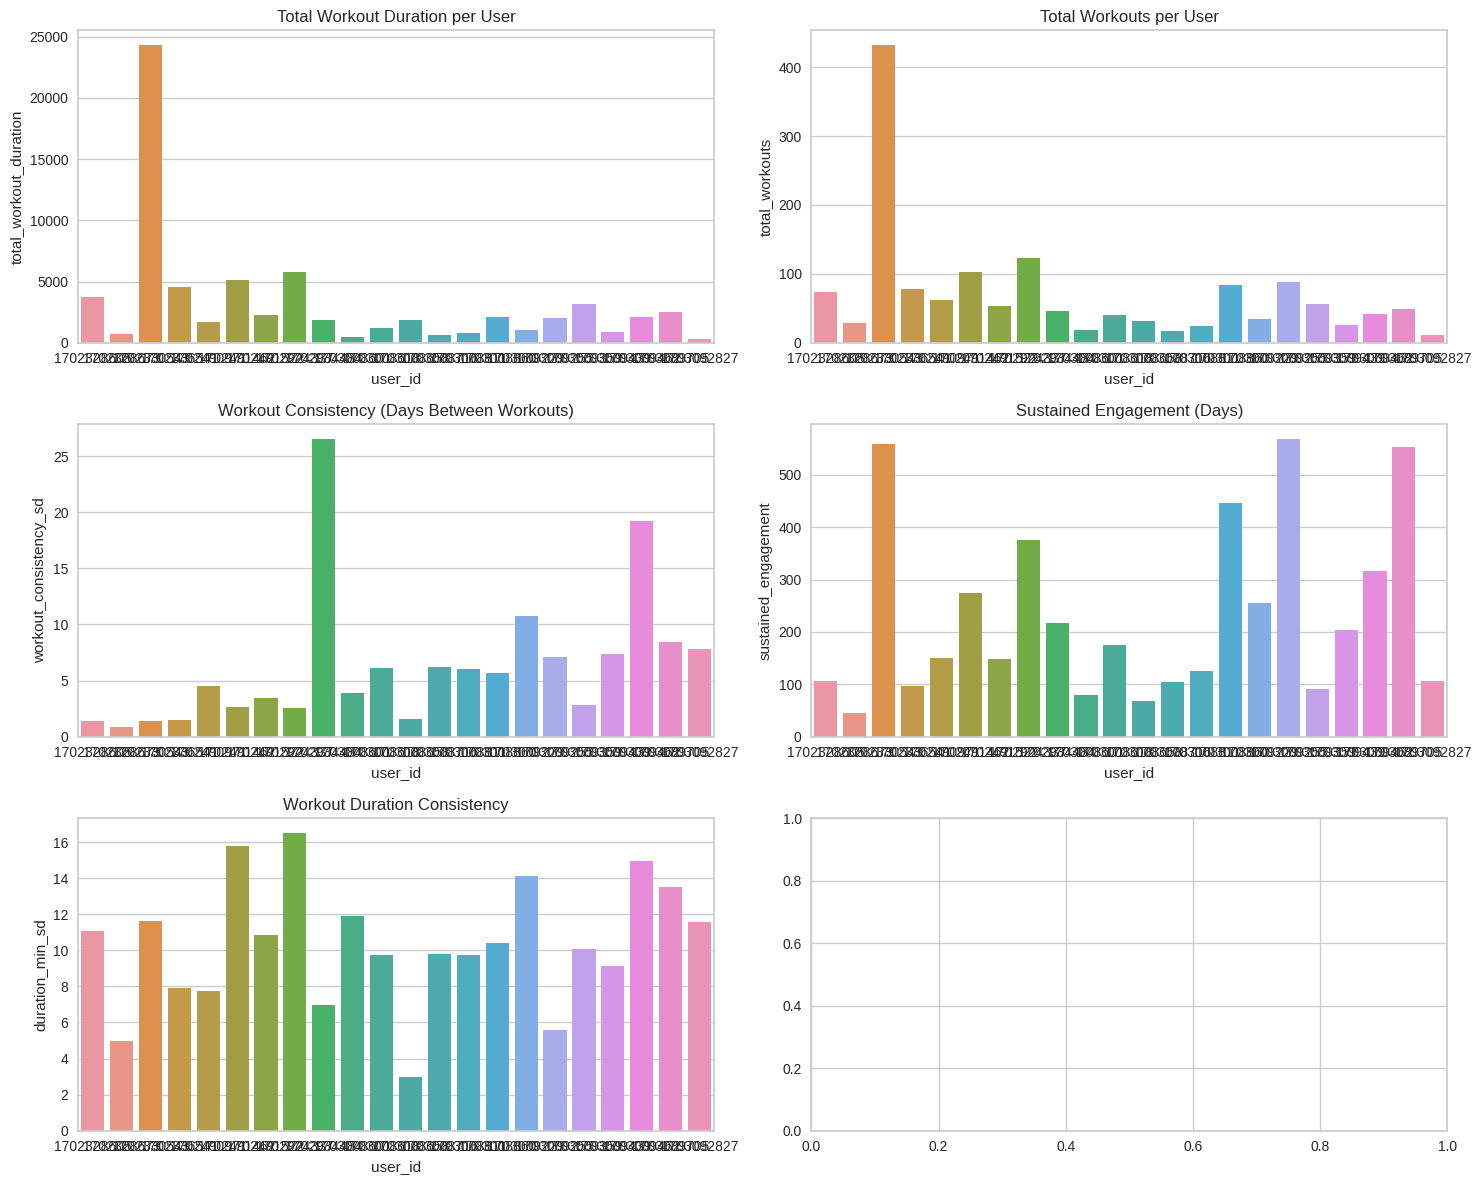

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up subplots for each feature
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Total Workout Duration
sns.barplot(x='user_id', y='total_workout_duration', data=longevity_metrics_v2, ax=axes[0, 0])
axes[0, 0].set_title('Total Workout Duration per User')

# Total Workouts
sns.barplot(x='user_id', y='total_workouts', data=longevity_metrics_v2, ax=axes[0, 1])
axes[0, 1].set_title('Total Workouts per User')

# Workout Consistency (Standard Deviation of Days Between Workouts)
sns.barplot(x='user_id', y='workout_consistency_sd', data=longevity_metrics_v2, ax=axes[1, 0])
axes[1, 0].set_title('Workout Consistency (Days Between Workouts)')

# Sustained Engagement (Time Span from First to Last Workout)
sns.barplot(x='user_id', y='sustained_engagement', data=longevity_metrics_v2, ax=axes[1, 1])
axes[1, 1].set_title('Sustained Engagement (Days)')

# Workout Duration Consistency (Standard Deviation of duration_min)
sns.barplot(x='user_id', y='duration_min_sd', data=longevity_metrics_v2, ax=axes[2, 0])
axes[2, 0].set_title('Workout Duration Consistency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [74]:
# Scale features for device-1:

longevity_metrics_v1 = pd.DataFrame(longevity_metrics_v1)

# Drop user_id for modeling purposes
longevity_df_v1 = longevity_metrics_v1.drop(columns=['user_id'])

# Standardize the features
scaler_v1 = StandardScaler()
scaled_features_v1 = scaler_v1.fit_transform(longevity_df_v1)

# Convert back to DataFrame for easier handling
scaled_df_v1 = pd.DataFrame(scaled_features_v1, columns=longevity_df_v1.columns)
print(scaled_df_v1.head())

   total_workout_duration  total_workouts  workout_consistency_sd  \
0                1.820416        1.504293               -0.572925   
1                0.669676        0.770805               -0.559387   
2                1.874115        1.646466               -0.526969   
3                0.169240        0.069631               -0.439002   
4                0.423460        0.958216               -0.216336   

   sustained_engagement  duration_min_sd  
0              2.113478        -1.055760  
1              0.351169         0.419288  
2              2.202115        -0.314948  
3             -0.735935         0.691795  
4              1.002911         0.093869  


In [75]:
# Scale features for device-2:

longevity_metrics_v2 = pd.DataFrame(longevity_metrics_v2)

# Drop user_id for modeling purposes
longevity_df_v2 = longevity_metrics_v2.drop(columns=['user_id'])

# Standardize the features
scaler_v2 = StandardScaler()
scaled_features_v2 = scaler_v2.fit_transform(longevity_df_v2)

# Convert back to DataFrame for easier handling
scaled_df_v2 = pd.DataFrame(scaled_features_v2, columns=longevity_df_v2.columns)
print(scaled_df_v2.head())

   total_workout_duration  total_workouts  workout_consistency_sd  \
0                0.129100        0.045331               -0.813811   
1               -0.502443       -0.488927               -0.902715   
2                4.362597        4.307525               -0.809683   
3                0.289612        0.104693               -0.805232   
4               -0.296599       -0.085265               -0.294278   

   sustained_engagement  duration_min_sd  
0             -0.747842         0.229600  
1             -1.117766        -1.580060  
2              1.987170         0.381740  
3             -0.814550        -0.706649  
4             -0.487076        -0.751953  


/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

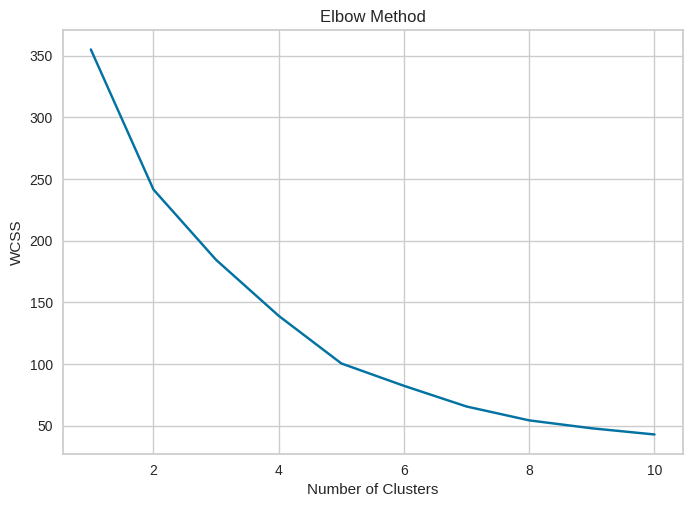

In [76]:
# Find number of clusters for device-1 using KMeans Clustering (Elbow Method)

from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_df_v1)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

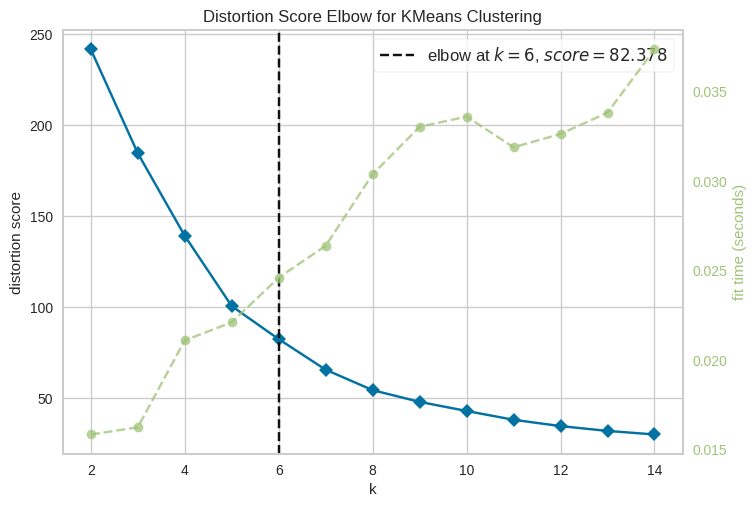

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
# Find number of clusters for device-1 using KMeans Clustering (Yellowbrick method)

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 15))

# Fit the data to the visualizer
visualizer.fit(scaled_df_v1)

# Finalize and render the figure
visualizer.show()

/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

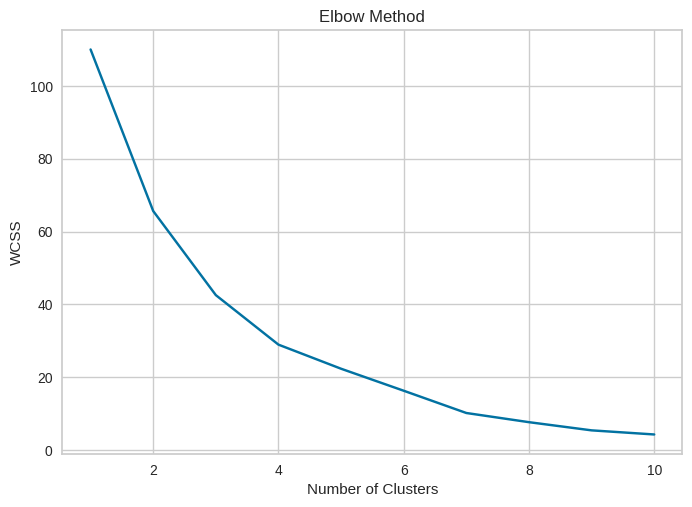

In [78]:
# Find number of clusters for device-2 using KMeans Clustering (Elbow Method)

from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_df_v2)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

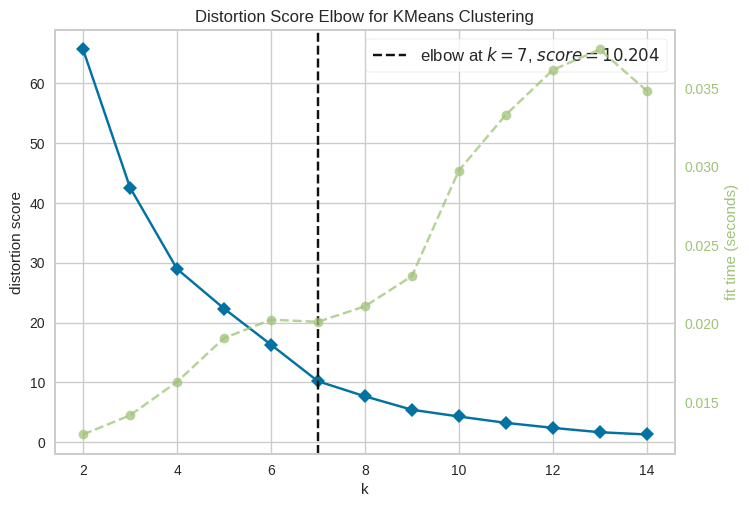

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [79]:
# Find number of clusters for device-2 using KMeans Clustering (Yellowbrick method)

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 15))

# Fit the data to the visualizer
visualizer.fit(scaled_df_v2)

# Finalize and render the figure
visualizer.show()

In [80]:
# No. of clusters for device-1: 6
# No. of clusters for device-2: 7

In [81]:
# Fit K-Means with the optimal number of clusters for device-1

kmeans = KMeans(n_clusters=6, random_state=42)
longevity_metrics_v1['Cluster'] = kmeans.fit_predict(scaled_df_v1)

# Analyze cluster characteristics
print(longevity_metrics_v1.groupby('Cluster').mean())

              user_id  total_workout_duration  total_workouts  \
Cluster                                                         
0        1.702687e+09            15551.071429      355.428571   
1        1.703044e+09             2549.133333       64.200000   
2        1.702973e+09             4364.900000      157.750000   
3        1.703093e+09              168.500000       10.500000   
4        1.703108e+09           133057.000000     2443.000000   
5        1.702956e+09             3697.157895       80.947368   

         workout_consistency_sd  sustained_engagement  duration_min_sd  
Cluster                                                                 
0                     13.032892           1071.142857        13.702268  
1                     12.646279            250.933333         6.299414  
2                     22.340004            861.100000         8.152782  
3                    204.025584            767.000000         6.742503  
4                      0.841747          

/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [82]:
# Fit K-Means with the optimal number of clusters for device-2

kmeans = KMeans(n_clusters=7, random_state=42)
longevity_metrics_v2['Cluster'] = kmeans.fit_predict(scaled_df_v2)

# Analyze cluster characteristics
print(longevity_metrics_v2.groupby('Cluster').mean())

              user_id  total_workout_duration  total_workouts  \
Cluster                                                         
0        1.702934e+09             1844.000000       46.000000   
1        1.702799e+09             1787.181818       41.909091   
2        1.702331e+09            24312.000000      432.000000   
3        1.703009e+09             1553.500000       38.000000   
4        1.703036e+09             2213.333333       73.666667   
5        1.702708e+09             5457.500000      113.000000   
6        1.702669e+09             1295.500000       30.000000   

         workout_consistency_sd  sustained_engagement  duration_min_sd  
Cluster                                                                 
0                     26.501534            218.000000         6.956455  
1                      4.642863            126.090909         9.955909  
2                      1.433788            558.000000        11.604130  
3                     14.993703            286.00

/usr/local/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


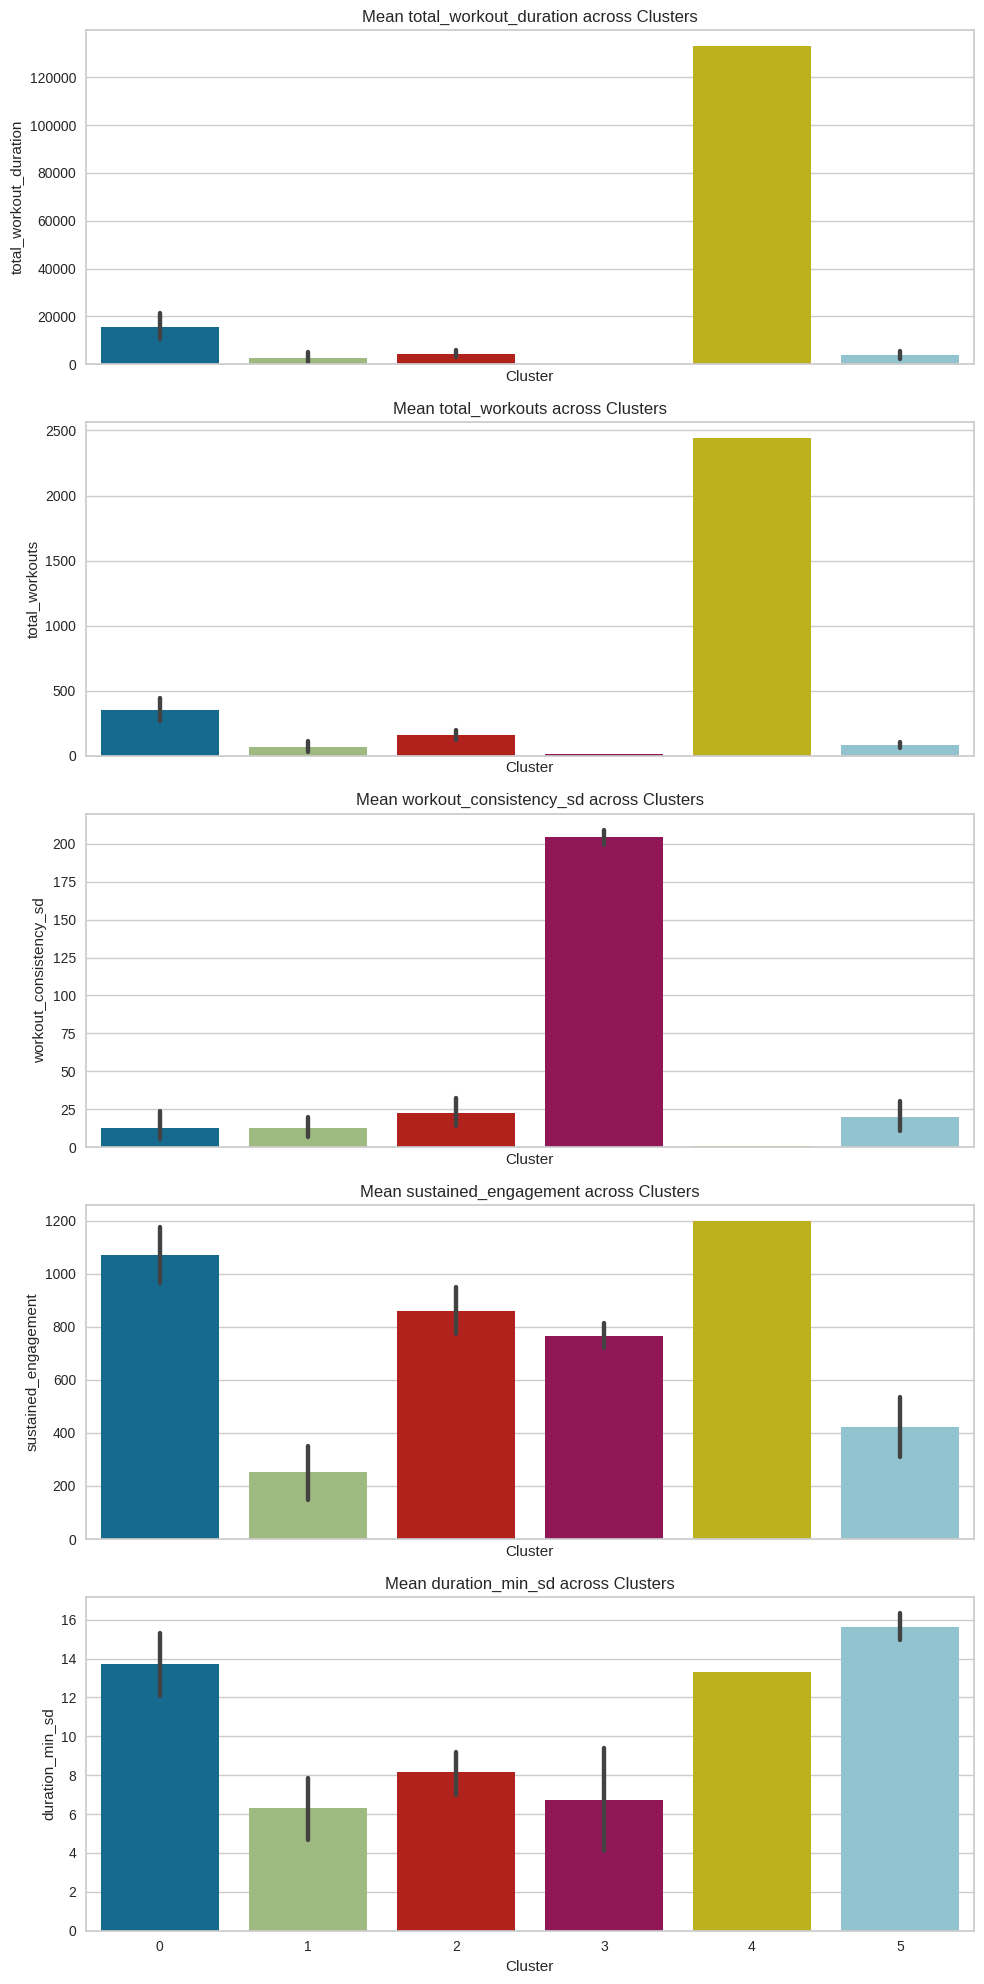

In [83]:
# Visualize Mean for all Clusters (and engineered features) for device-1

# Define the engineered features to visualize
engineered_features = ['total_workout_duration', 'total_workouts', 'workout_consistency_sd',
                       'sustained_engagement', 'duration_min_sd']

# Plotting cluster characteristics
fig, axes = plt.subplots(nrows=len(engineered_features), ncols=1, figsize=(10, 20), sharex=True)

for i, feature in enumerate(engineered_features):
    sns.barplot(x='Cluster', y=feature, data=longevity_metrics_v1, ax=axes[i])
    axes[i].set_title(f'Mean {feature} across Clusters')
    axes[i].set_ylabel(feature)

plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

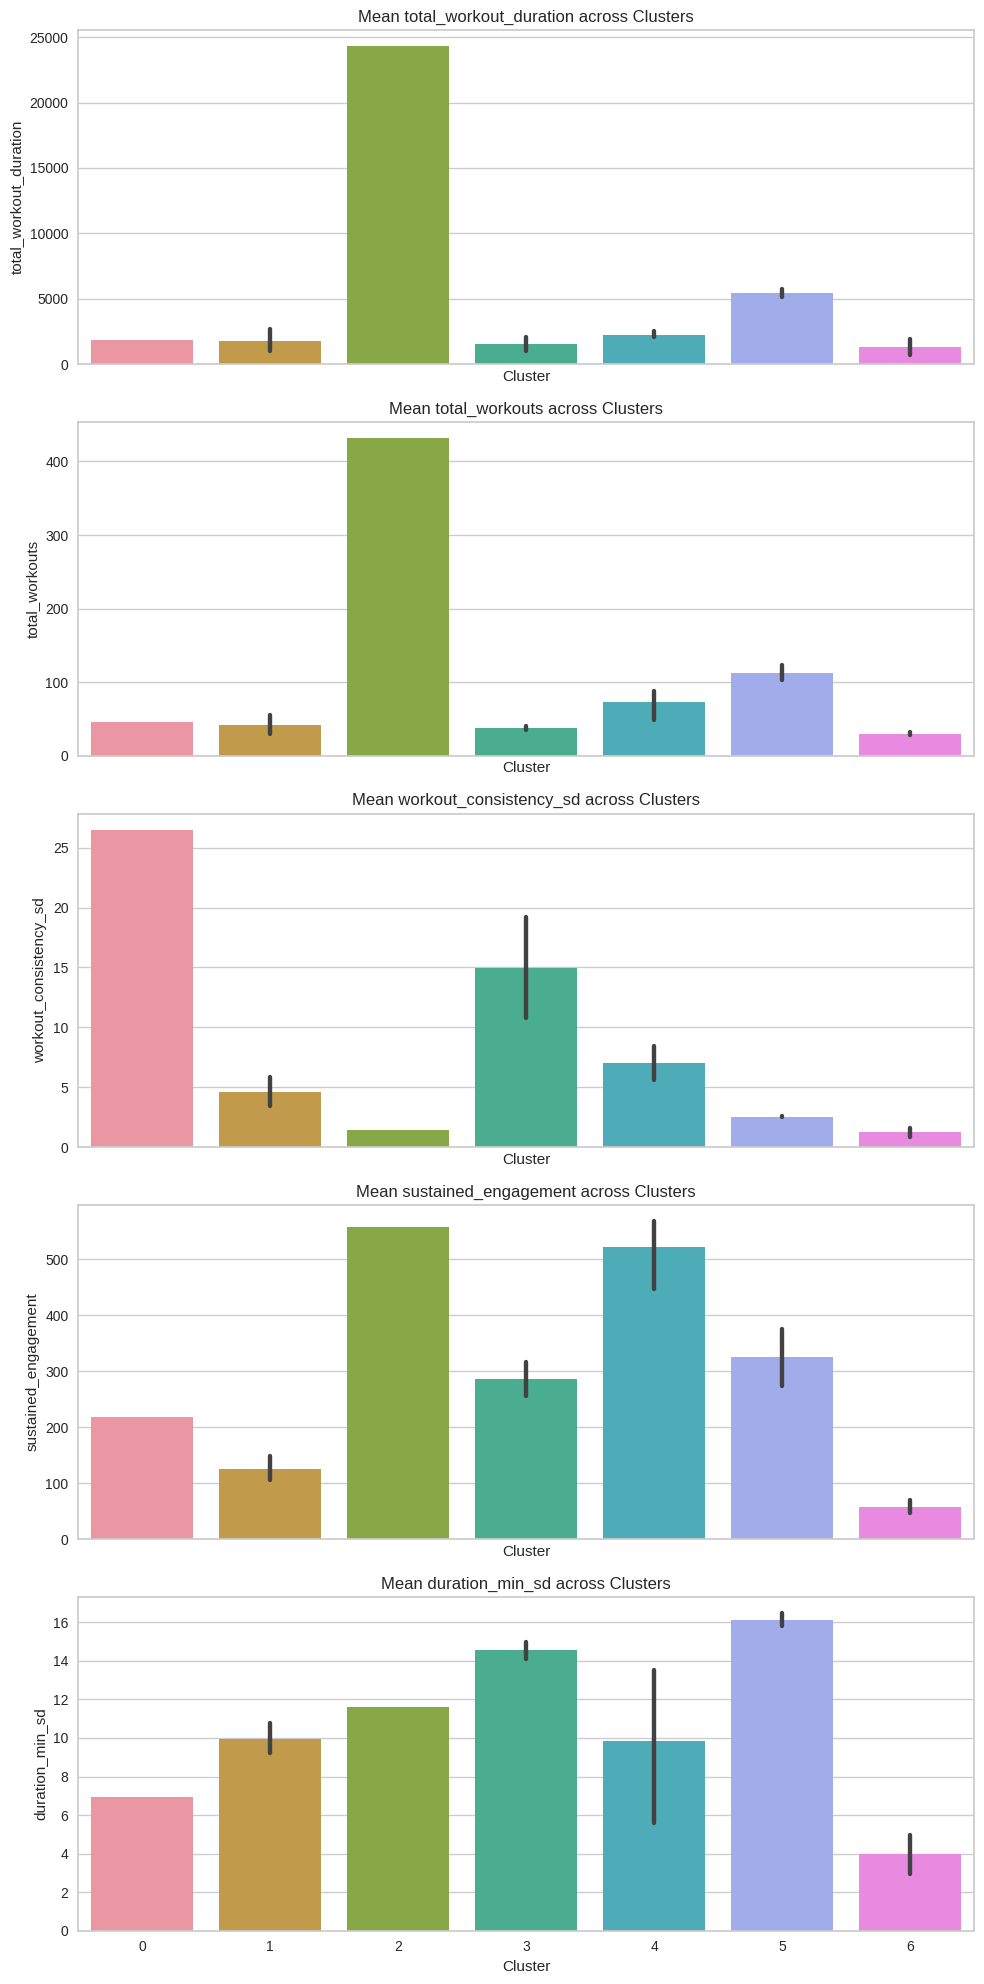

In [84]:
# Visualize Mean for all Clusters (and engineered features) for device-2

# Define the engineered features to visualize
engineered_features = ['total_workout_duration', 'total_workouts', 'workout_consistency_sd',
                       'sustained_engagement', 'duration_min_sd']

# Plotting cluster characteristics
fig, axes = plt.subplots(nrows=len(engineered_features), ncols=1, figsize=(10, 20), sharex=True)

for i, feature in enumerate(engineered_features):
    sns.barplot(x='Cluster', y=feature, data=longevity_metrics_v2, ax=axes[i])
    axes[i].set_title(f'Mean {feature} across Clusters')
    axes[i].set_ylabel(feature)
    axes[i].set_xlabel('Cluster')  # Ensure x-axis label is set for each subplot

plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

Feature Importances:
duration_min_sd           0.332866
sustained_engagement      0.267361
total_workout_duration    0.163269
total_workouts            0.157721
workout_consistency_sd    0.078784
dtype: float64


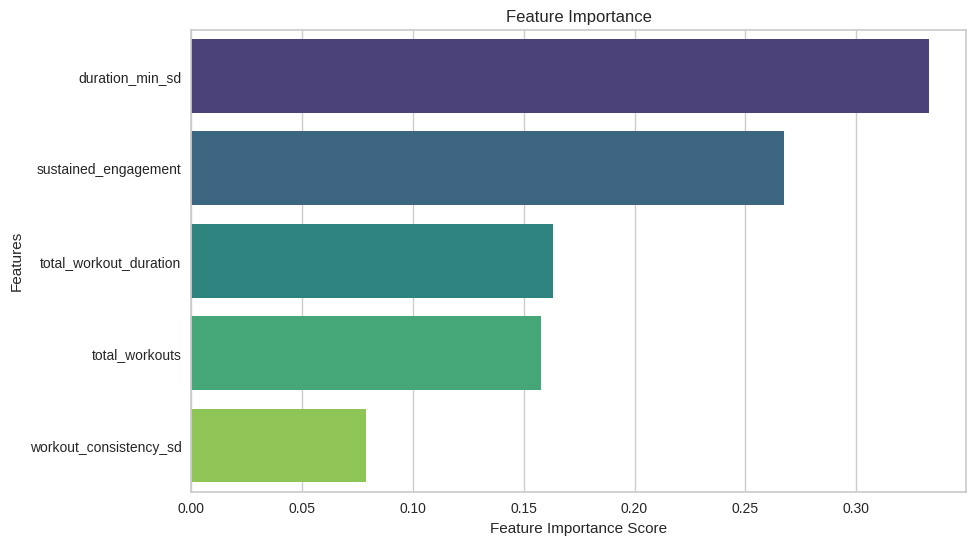

In [85]:
# Feature Importance for device-1: Determine which engineered features contribute most to cluster differentiation 

from sklearn.ensemble import RandomForestClassifier

X = scaled_df_v1  # Features
y = longevity_metrics_v1['Cluster']  # Target variable

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print('Feature Importances:')
print(feature_importances_sorted)



# Plotting feature importances for device-1:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_sorted.values, y=feature_importances_sorted.index, palette='viridis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


Feature Importances:
sustained_engagement      0.351834
duration_min_sd           0.244551
workout_consistency_sd    0.157029
total_workouts            0.146355
total_workout_duration    0.100231
dtype: float64


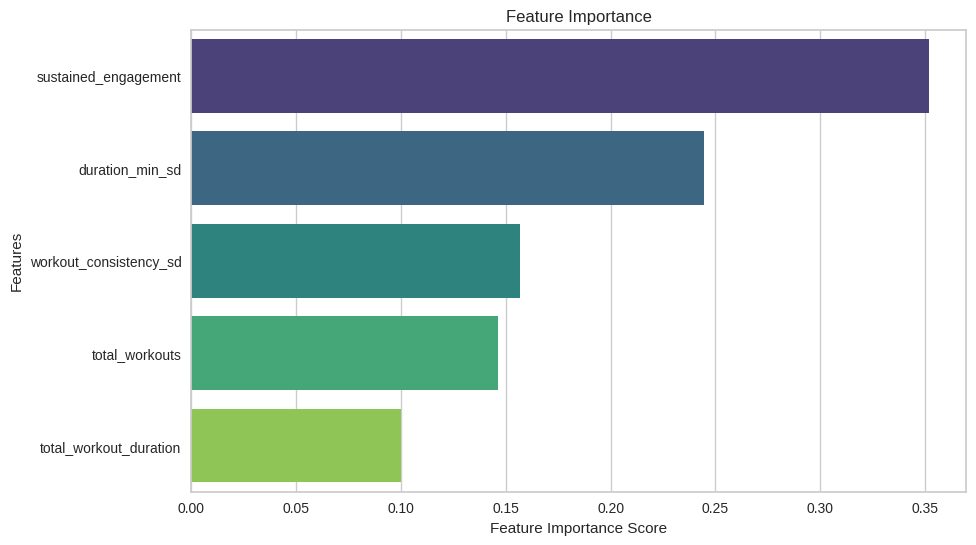

In [86]:
# Feature Importance for device-2: Determine which engineered features contribute most to cluster differentiation 

from sklearn.ensemble import RandomForestClassifier

X = scaled_df_v2  # Features
y = longevity_metrics_v2['Cluster']  # Target variable

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print('Feature Importances:')
print(feature_importances_sorted)


# Plotting feature importances for device-2:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_sorted.values, y=feature_importances_sorted.index, palette='viridis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [87]:
# Print user_id list for all the clusters for device-1

cluster_0_v1_users = longevity_metrics_v1[longevity_metrics_v1['Cluster'] == 0]['user_id'].tolist()
cluster_1_v1_users = longevity_metrics_v1[longevity_metrics_v1['Cluster'] == 1]['user_id'].tolist()
cluster_2_v1_users = longevity_metrics_v1[longevity_metrics_v1['Cluster'] == 2]['user_id'].tolist()
cluster_3_v1_users = longevity_metrics_v1[longevity_metrics_v1['Cluster'] == 3]['user_id'].tolist()
cluster_4_v1_users = longevity_metrics_v1[longevity_metrics_v1['Cluster'] == 4]['user_id'].tolist()
cluster_5_v1_users = longevity_metrics_v1[longevity_metrics_v1['Cluster'] == 5]['user_id'].tolist()

print("User IDs in Cluster 0:", cluster_0_v1_users)
print("User IDs in Cluster 1:", cluster_1_v1_users)
print("User IDs in Cluster 2:", cluster_2_v1_users)
print("User IDs in Cluster 3:", cluster_3_v1_users)
print("User IDs in Cluster 4:", cluster_4_v1_users)
print("User IDs in Cluster 5:", cluster_5_v1_users)

User IDs in Cluster 0: [1702329495, 1702333022, 1702333567, 1702336610, 1702490242, 1702490592, 1702490893, 1702922137, 1702922500, 1702923181, 1702935311, 1703008928, 1703009496, 1703089326]
User IDs in Cluster 1: [1702933150, 1702934123, 1702935842, 1703008693, 1703008907, 1703009028, 1703089640, 1703089748, 1703092110, 1703092207, 1703092794, 1703092810, 1703092908, 1703093190, 1703093228]
User IDs in Cluster 2: [1702490345, 1702922923, 1702924714, 1702931295, 1702931398, 1702934205, 1702935394, 1702935657, 1702935769, 1703008735, 1703009051, 1703009164, 1703009294, 1703009403, 1703009575, 1703089540, 1703089571, 1703089606, 1703092168, 1703092871]
User IDs in Cluster 3: [1703092894, 1703093176]
User IDs in Cluster 4: [1703107708]
User IDs in Cluster 5: [1702336416, 1702490329, 1702924246, 1702924413, 1702924516, 1702924633, 1702933226, 1702934516, 1702935733, 1703009094, 1703089411, 1703089659, 1703091959, 1703092008, 1703092049, 1703092087, 1703092147, 1703092185, 1703092780]


In [116]:
# Print user_id list for all the clusters for device-2

cluster_0_v2_users = longevity_metrics_v2[longevity_metrics_v2['Cluster'] == 0]['user_id'].tolist()
cluster_1_v2_users = longevity_metrics_v2[longevity_metrics_v2['Cluster'] == 1]['user_id'].tolist()
cluster_2_v2_users = longevity_metrics_v2[longevity_metrics_v2['Cluster'] == 2]['user_id'].tolist()
cluster_3_v2_users = longevity_metrics_v2[longevity_metrics_v2['Cluster'] == 3]['user_id'].tolist()
cluster_4_v2_users = longevity_metrics_v2[longevity_metrics_v2['Cluster'] == 4]['user_id'].tolist()
cluster_5_v2_users = longevity_metrics_v2[longevity_metrics_v2['Cluster'] == 5]['user_id'].tolist()
cluster_6_v2_users = longevity_metrics_v2[longevity_metrics_v2['Cluster'] == 6]['user_id'].tolist()

print("User IDs in Cluster 0:", cluster_0_v2_users)
print("User IDs in Cluster 1:", cluster_1_v2_users)
print("User IDs in Cluster 2:", cluster_2_v2_users)
print("User IDs in Cluster 3:", cluster_3_v2_users)
print("User IDs in Cluster 4:", cluster_4_v2_users)
print("User IDs in Cluster 5:", cluster_5_v2_users)
print("User IDs in Cluster 6:", cluster_6_v2_users)

User IDs in Cluster 0: [1702934484]
User IDs in Cluster 1: [1702328605, 1702336541, 1702490971, 1702491522, 1703008601, 1703008618, 1703008716, 1703008811, 1703009359, 1703009439, 1703092827]
User IDs in Cluster 2: [1702330543]
User IDs in Cluster 3: [1703009229, 1703009462]
User IDs in Cluster 4: [1703008860, 1703009255, 1703089705]
User IDs in Cluster 5: [1702491462, 1702924337]
User IDs in Cluster 6: [1702328673, 1703008658]


In [89]:
print(longevity_metrics_v2[longevity_metrics_v2['Cluster'] == 1]['workout_consistency_sd'].tolist())

[1.4091557312108485, 1.4603438765809222, 4.5091285673795625, 3.4495114397134676, 3.887721580176147, 6.137867244002044, 6.1802777715353, 6.012065164004119, 2.8477647918612083, 7.396620850090939, 7.781031065639337]


In [90]:
# Is consistency associated with better outcomes?

In [91]:
# Approach-1: 

# Define outcome metrics
outcome_metrics = ['calories_kcal', 'avg_power_mi', 'distance_mi', 'spasm_count', 'duration_min']

# Calculate average outcome metrics per user
user_outcomes_v1 = summary_df_v1.groupby('user_id')[outcome_metrics].mean().reset_index()

# Merge consistency metrics with user outcomes
user_metrics_v1 = longevity_metrics_v1[['user_id', 'duration_min_sd', 'workout_consistency_sd', 'total_workout_duration', 
                                            'total_workouts', 'sustained_engagement']]
user_metrics_v1 = pd.merge(user_metrics_v1, user_outcomes_v1, on='user_id')

               duration_min_sd  workout_consistency_sd  \
calories_kcal         0.396429               -0.236917   
avg_power_mi         -0.003182               -0.004063   
distance_mi           0.490421               -0.338199   
spasm_count          -0.065890               -0.025571   
duration_min          0.503853               -0.344884   

               total_workout_duration  total_workouts  sustained_engagement  
calories_kcal                0.261819        0.237480              0.219512  
avg_power_mi                -0.051092       -0.017009              0.117807  
distance_mi                  0.401774        0.329662              0.120926  
spasm_count                 -0.061558       -0.042744              0.047480  
duration_min                 0.402985        0.332493              0.123262  


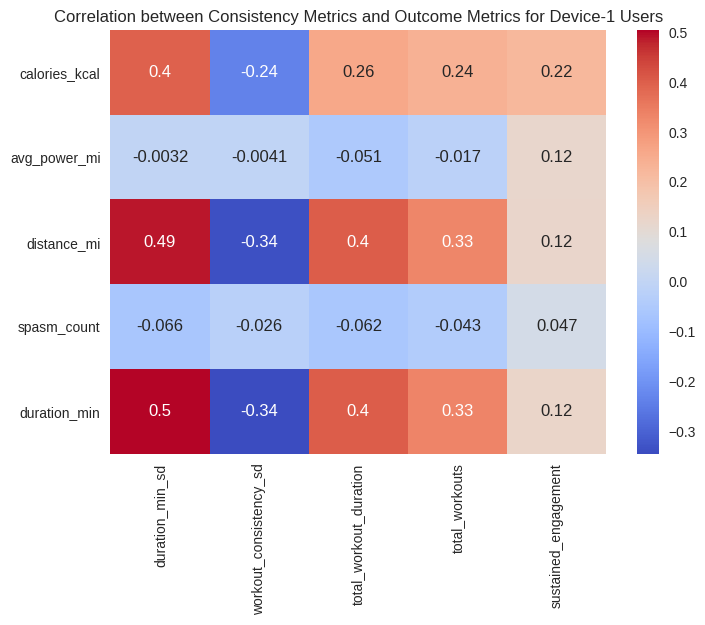

In [92]:
# Calculate correlation between consistency metrics and outcome metrics for device-1:

from scipy.stats import pearsonr

correlations = {}
for outcome in outcome_metrics:
    corr_duration_sd, _ = pearsonr(user_metrics_v1['duration_min_sd'], user_metrics_v1[outcome])
    corr_consistency_sd, _ = pearsonr(user_metrics_v1['workout_consistency_sd'], user_metrics_v1[outcome])
    corr_total_workout_duration, _ = pearsonr(user_metrics_v1['total_workout_duration'], user_metrics_v1[outcome])
    corr_total_workouts, _ = pearsonr(user_metrics_v1['total_workouts'], user_metrics_v1[outcome])
    corr_sustained_engagement, _ = pearsonr(user_metrics_v1['sustained_engagement'], user_metrics_v1[outcome])
    correlations[outcome] = {'duration_min_sd': corr_duration_sd, 'workout_consistency_sd': corr_consistency_sd, 
                            'total_workout_duration': corr_total_workout_duration, 'total_workouts': corr_total_workouts, 
                            'sustained_engagement': corr_sustained_engagement}

# Display correlation results
correlation_df_v1 = pd.DataFrame(correlations).T
print(correlation_df_v1)

# Visualize correlations
sns.heatmap(correlation_df_v1, annot=True, cmap='coolwarm')
plt.title('Correlation between Consistency Metrics and Outcome Metrics for Device-1 Users')
plt.show()

In [93]:
# High Correlation using Approach-1:
# Calories <-> SD of Workout Duration, Total Workout Duration, Total Workouts, Sustained Engagement
# Distance <-> SD of Workout Duration, Total Workout Duration, Total Workouts, Sustained Engagement
# Duration <-> SD of Workout Duration, Total Workout Duration, Total Workouts, Sustained Engagement

# None of the longevity metrics have a high correlation with Spasm Count

In [94]:
# Hypothesis Testing for device-1:

from scipy.stats import ttest_ind

# Define high and low consistency categories based on median split
threshold_duration_sd_v1 = user_metrics_v1['duration_min_sd'].median()
threshold_consistency_sd_v1 = user_metrics_v1['workout_consistency_sd'].median()

user_metrics_v1['high_duration_consistency'] = user_metrics_v1['duration_min_sd'] < threshold_duration_sd_v1
user_metrics_v1['high_workout_consistency'] = user_metrics_v1['workout_consistency_sd'] < threshold_consistency_sd_v1

# Perform t-tests
ttest_results = {}
for outcome in outcome_metrics:
    high_duration_group = user_metrics_v1[user_metrics_v1['high_duration_consistency']][outcome]
    low_duration_group = user_metrics_v1[~user_metrics_v1['high_duration_consistency']][outcome]
    t_stat_duration, p_val_duration = ttest_ind(high_duration_group, low_duration_group)
    
    high_consistency_group = user_metrics_v1[user_metrics_v1['high_workout_consistency']][outcome]
    low_consistency_group = user_metrics_v1[~user_metrics_v1['high_workout_consistency']][outcome]
    t_stat_consistency, p_val_consistency = ttest_ind(high_consistency_group, low_consistency_group)
    
    ttest_results[outcome] = {'t_stat_duration': t_stat_duration, 'p_val_duration': p_val_duration,
                              't_stat_consistency': t_stat_consistency, 'p_val_consistency': p_val_consistency}

# Display t-test results
ttest_df_v1 = pd.DataFrame(ttest_results).T
print(ttest_df_v1)

               t_stat_duration  p_val_duration  t_stat_consistency  \
calories_kcal        -2.469805        0.015996            2.502426   
avg_power_mi          1.142580        0.257162            0.374031   
distance_mi          -4.539936        0.000023            3.358760   
spasm_count           0.639805        0.524418           -1.217169   
duration_min         -4.694292        0.000013            3.425884   

               p_val_consistency  
calories_kcal           0.014708  
avg_power_mi            0.709528  
distance_mi             0.001278  
spasm_count             0.227687  
duration_min            0.001036  


In [95]:
# Summary for Approach-1:
# Calories Burned: Higher workout consistency and lower duration consistency are associated with more calories burned.
# Distance Cycled: Higher workout consistency and lower duration consistency are associated with longer distances cycled.
# Spasm Count: No significant difference based on consistency metrics.
# Workout Duration: Higher workout consistency and lower duration consistency are associated with longer workout durations.

# Conclusion:
# These results suggest that while higher workout consistency generally leads to better outcomes (more calories burned, 
#     longer distances cycled, longer workout durations), lower duration consistency (indicating more variation in workout 
#     durations) also appears to have positive associations with these metrics. 
# This might indicate that a balance of consistency with some variation could lead to optimal outcomes.

               duration_min_sd  workout_consistency_sd  \
calories_kcal         0.121208               -0.078815   
avg_power_mi         -0.195185                0.160824   
distance_mi           0.163689               -0.116936   
spasm_count          -0.040543               -0.002349   
duration_min          0.170930               -0.125734   

               total_workout_duration  total_workouts  sustained_engagement  
calories_kcal                0.506217        0.420759              0.127393  
avg_power_mi                -0.024842        0.038770              0.008007  
distance_mi                  0.474025        0.372714              0.053677  
spasm_count                 -0.122317       -0.126115             -0.069583  
duration_min                 0.470483        0.368920              0.052248  


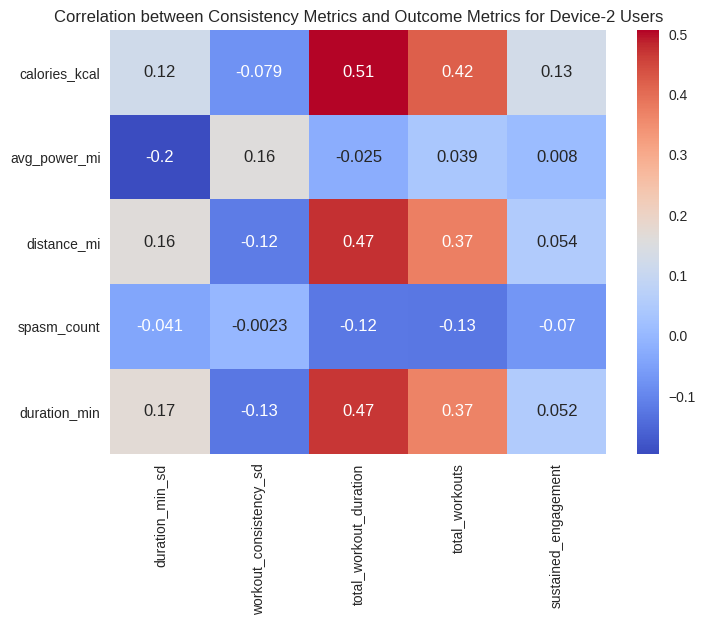

In [97]:
# Approach-1 for device-2 dataset:

# Define outcome metrics
outcome_metrics = ['calories_kcal', 'avg_power_mi', 'distance_mi', 'spasm_count', 'duration_min']

# Calculate average outcome metrics per user
user_outcomes_v2 = summary_df_v2.groupby('user_id')[outcome_metrics].mean().reset_index()

# Merge consistency metrics with user outcomes
user_metrics_v2 = longevity_metrics_v2[['user_id', 'duration_min_sd', 'workout_consistency_sd', 'total_workout_duration', 
                                            'total_workouts', 'sustained_engagement']]
user_metrics_v2 = pd.merge(user_metrics_v2, user_outcomes_v2, on='user_id')


# Calculate correlation between consistency metrics and outcome metrics for device-2:

correlations = {}
for outcome in outcome_metrics:
    corr_duration_sd, _ = pearsonr(user_metrics_v2['duration_min_sd'], user_metrics_v2[outcome])
    corr_consistency_sd, _ = pearsonr(user_metrics_v2['workout_consistency_sd'], user_metrics_v2[outcome])
    corr_total_workout_duration, _ = pearsonr(user_metrics_v2['total_workout_duration'], user_metrics_v2[outcome])
    corr_total_workouts, _ = pearsonr(user_metrics_v2['total_workouts'], user_metrics_v2[outcome])
    corr_sustained_engagement, _ = pearsonr(user_metrics_v2['sustained_engagement'], user_metrics_v2[outcome])
    correlations[outcome] = {'duration_min_sd': corr_duration_sd, 'workout_consistency_sd': corr_consistency_sd, 
                            'total_workout_duration': corr_total_workout_duration, 'total_workouts': corr_total_workouts, 
                            'sustained_engagement': corr_sustained_engagement}

# Display correlation results
correlation_df_v2 = pd.DataFrame(correlations).T
print(correlation_df_v2)

# Visualize correlations
sns.heatmap(correlation_df_v2, annot=True, cmap='coolwarm')
plt.title('Correlation between Consistency Metrics and Outcome Metrics for Device-2 Users')
plt.show()

In [98]:
# High Correlation using Approach-2:
# Calories <-> SD of Workout Duration, Total Workout Duration, Total Workouts, Sustained Engagement
# Distance <-> SD of Workout Duration, Total Workout Duration, Total Workouts, Sustained Engagement
# Duration <-> SD of Workout Duration, Total Workout Duration, Total Workouts, Sustained Engagement

# None of the longevity metrics have a high correlation with Spasm Count

In [99]:
# Hypothesis Testing for device-2:

# Define high and low consistency categories based on median split
threshold_duration_sd_v2 = user_metrics_v2['duration_min_sd'].median()
threshold_consistency_sd_v2 = user_metrics_v2['workout_consistency_sd'].median()

user_metrics_v2['high_duration_consistency'] = user_metrics_v2['duration_min_sd'] < threshold_duration_sd_v2
user_metrics_v2['high_workout_consistency'] = user_metrics_v2['workout_consistency_sd'] < threshold_consistency_sd_v2

# Perform t-tests
ttest_results = {}
for outcome in outcome_metrics:
    high_duration_group = user_metrics_v2[user_metrics_v2['high_duration_consistency']][outcome]
    low_duration_group = user_metrics_v2[~user_metrics_v2['high_duration_consistency']][outcome]
    t_stat_duration, p_val_duration = ttest_ind(high_duration_group, low_duration_group)
    
    high_consistency_group = user_metrics_v2[user_metrics_v2['high_workout_consistency']][outcome]
    low_consistency_group = user_metrics_v2[~user_metrics_v2['high_workout_consistency']][outcome]
    t_stat_consistency, p_val_consistency = ttest_ind(high_consistency_group, low_consistency_group)
    
    ttest_results[outcome] = {'t_stat_duration': t_stat_duration, 'p_val_duration': p_val_duration,
                              't_stat_consistency': t_stat_consistency, 'p_val_consistency': p_val_consistency}

# Display t-test results
ttest_df_v2 = pd.DataFrame(ttest_results).T
print(ttest_df_v2)

               t_stat_duration  p_val_duration  t_stat_consistency  \
calories_kcal        -0.269304        0.790455            2.306516   
avg_power_mi          1.192214        0.247132            0.497706   
distance_mi          -0.476983        0.638545            2.229846   
spasm_count           1.279478        0.215374           -1.118191   
duration_min         -0.607602        0.550289            2.243361   

               p_val_consistency  
calories_kcal           0.031913  
avg_power_mi            0.624119  
distance_mi             0.037378  
spasm_count             0.276737  
duration_min            0.036357  


In [ ]:
# Summary for Approach-1 for device-2:
# Calories Burned: Higher workout consistency and lower duration consistency are associated with more calories burned.
# Distance Cycled: Higher workout consistency and lower duration consistency are associated with longer distances cycled.
# Spasm Count: No significant difference based on consistency metrics.
# Workout Duration: Higher workout consistency and lower duration consistency are associated with longer workout durations.

# Conclusion:
# These results suggest that while higher workout consistency generally leads to better outcomes (more calories burned, 
#     longer distances cycled, longer workout durations), lower duration consistency (indicating more variation in workout 
#     durations) also appears to have positive associations with these metrics. 
# This might indicate that a balance of consistency with some variation could lead to optimal outcomes.

In [100]:
# Approach-2 for device-1:

# Aggregate to get mean avg_power_mi and mean spasm_count per user
user_outcomes_v1 = summary_df_v1.groupby('user_id').agg({
    'avg_power_mi': 'mean',
    'spasm_count': 'mean'
}).reset_index()
user_outcomes_v1.columns = ['user_id', 'mean_avg_power_mi', 'mean_spasm_count']

# Merge the longevity metrics with the user outcomes
longevity_outcomes_v1 = pd.merge(longevity_metrics_v1, user_outcomes_v1, on='user_id')


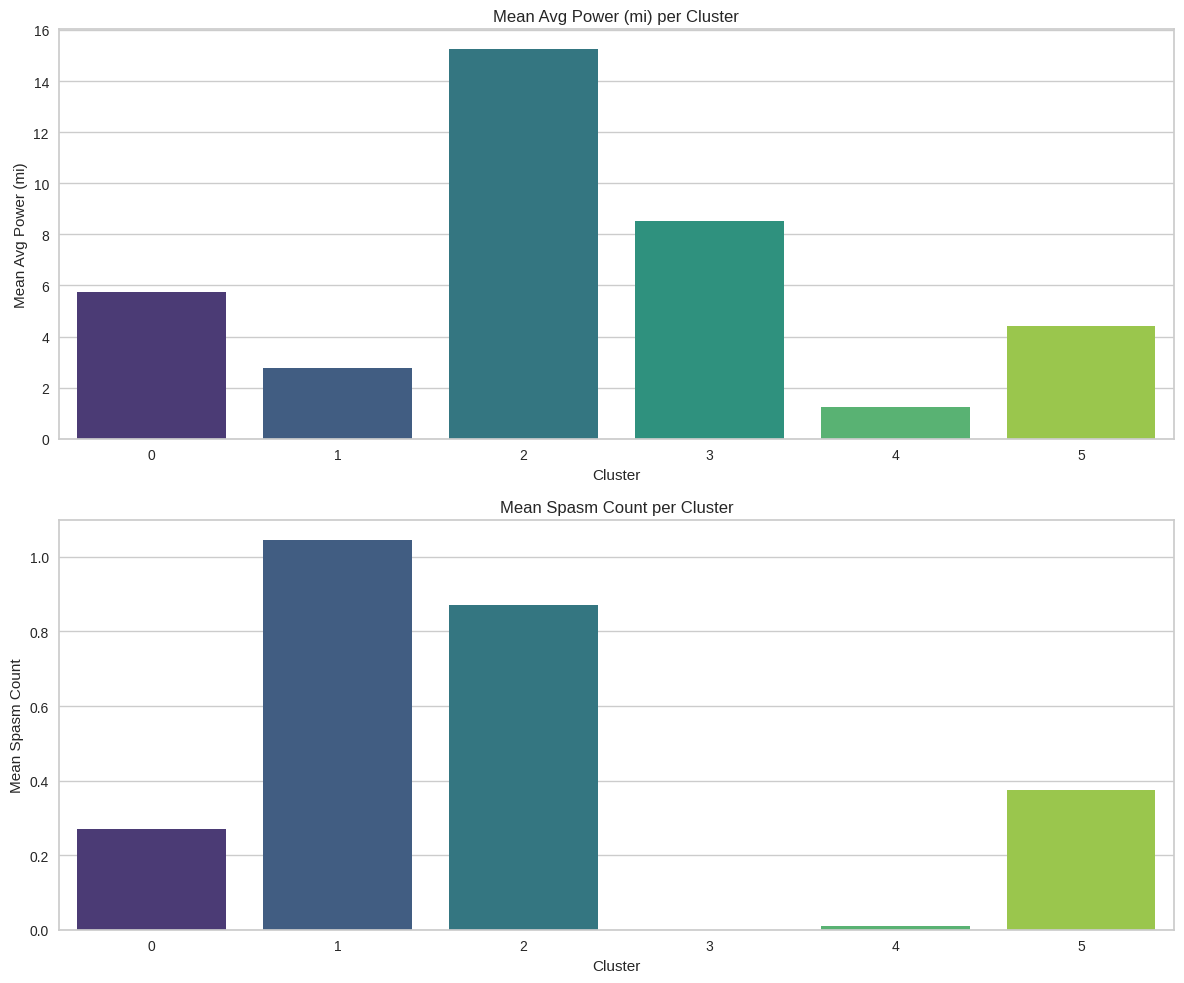

In [101]:
# Merge the cluster information
# longevity_outcomes_v1 = longevity_outcomes_v1.merge(longevity_metrics_v1[['user_id', 'Cluster']], on='user_id')

# Analyze cluster performance
cluster_analysis = longevity_outcomes_v1.groupby('Cluster').agg({
    'mean_avg_power_mi': ['mean', 'std'],
    'mean_spasm_count': ['mean', 'std'],
    'duration_min_sd': ['mean', 'std'],
    'workout_consistency_sd': ['mean', 'std'],
    'total_workout_duration': ['mean', 'std'],
    'total_workouts': ['mean', 'std'],
    'sustained_engagement': ['mean', 'std']
}).reset_index()

# Flatten multi-level column names
cluster_analysis.columns = ['_'.join(col).strip() for col in cluster_analysis.columns.values]

# Sort clusters based on workout_consistency_sd (from good to worst)
cluster_analysis = cluster_analysis.sort_values(by='workout_consistency_sd_mean')

# Plot mean avg_power_mi and mean spasm_count for each cluster
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Avg Power
sns.barplot(x='Cluster_', y='mean_avg_power_mi_mean', data=cluster_analysis, ax=axes[0], palette='viridis')
axes[0].set_title('Mean Avg Power (mi) per Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Mean Avg Power (mi)')

# Spasm Count
sns.barplot(x='Cluster_', y='mean_spasm_count_mean', data=cluster_analysis, ax=axes[1], palette='viridis')
axes[1].set_title('Mean Spasm Count per Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Mean Spasm Count')

plt.tight_layout()
plt.show()


In [102]:
# High Mean Avg Power: Indicates better performance
#    Clusters (in best to worst order) that signifies better performance: 2, 3, 0, 5, 1, 4

# Low Mean Spasm Count: Indicates better performance
#    Clusters (in best to worst order) that signifies better performance: 3, 4, 0, 5, 2, 1

In [103]:
longevity_outcomes_v1.head()

,user_id,total_workout_duration,total_workouts,workout_consistency_sd,sustained_engagement,duration_min_sd,Cluster,mean_avg_power_mi,mean_spasm_count
0,1702329495,38179.0,650,1.467317,1469,5.999488,0,6.998462,0.000000
1,1702333022,18914.0,423,1.969172,793,12.833272,0,2.607565,1.229314
2,1702333567,39078.0,694,3.170901,1503,9.431611,0,2.466859,0.122478
3,1702336416,10536.0,206,6.431808,376,14.095775,5,0.839806,0.004854
4,1702336610,14792.0,481,14.685949,1043,11.325631,0,6.667360,0.201663


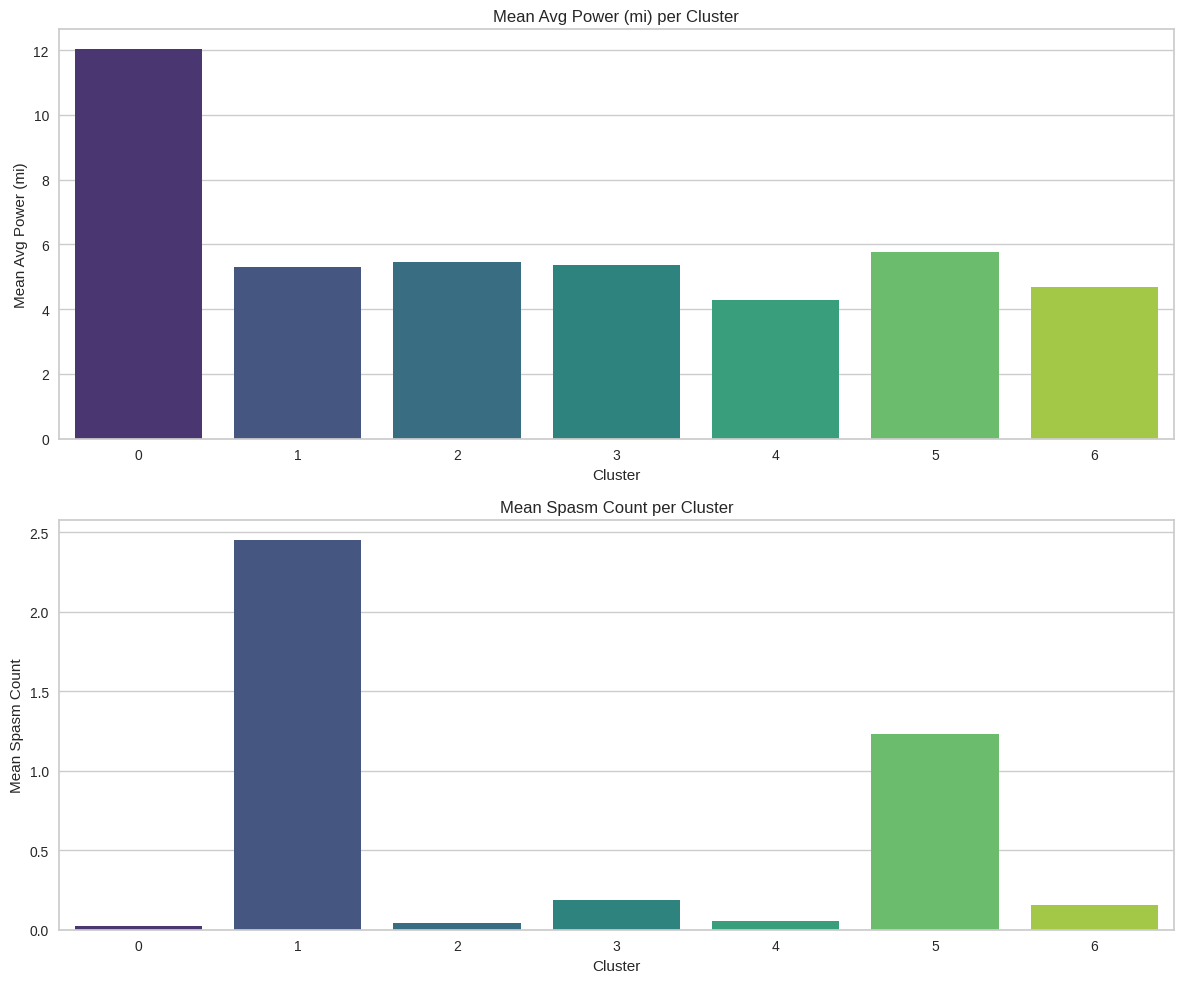

In [104]:
# Approach-2 for device-2:

# Aggregate to get mean avg_power_mi and mean spasm_count per user
user_outcomes_v2 = summary_df_v2.groupby('user_id').agg({
    'avg_power_mi': 'mean',
    'spasm_count': 'mean'
}).reset_index()
user_outcomes_v2.columns = ['user_id', 'mean_avg_power_mi', 'mean_spasm_count']

# Merge the longevity metrics with the user outcomes
longevity_outcomes_v2 = pd.merge(longevity_metrics_v2, user_outcomes_v2, on='user_id')

# Analyze cluster performance
cluster_analysis = longevity_outcomes_v2.groupby('Cluster').agg({
    'mean_avg_power_mi': ['mean', 'std'],
    'mean_spasm_count': ['mean', 'std'],
    'duration_min_sd': ['mean', 'std'],
    'workout_consistency_sd': ['mean', 'std'],
    'total_workout_duration': ['mean', 'std'],
    'total_workouts': ['mean', 'std'],
    'sustained_engagement': ['mean', 'std']
}).reset_index()

# Flatten multi-level column names
cluster_analysis.columns = ['_'.join(col).strip() for col in cluster_analysis.columns.values]

# Sort clusters based on workout_consistency_sd (from good to worst)
cluster_analysis = cluster_analysis.sort_values(by='workout_consistency_sd_mean')

# Plot mean avg_power_mi and mean spasm_count for each cluster
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Avg Power
sns.barplot(x='Cluster_', y='mean_avg_power_mi_mean', data=cluster_analysis, ax=axes[0], palette='viridis')
axes[0].set_title('Mean Avg Power (mi) per Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Mean Avg Power (mi)')

# Spasm Count
sns.barplot(x='Cluster_', y='mean_spasm_count_mean', data=cluster_analysis, ax=axes[1], palette='viridis')
axes[1].set_title('Mean Spasm Count per Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Mean Spasm Count')

plt.tight_layout()
plt.show()


In [ ]:
# High Mean Avg Power: Indicates better performance
#    Clusters (in best to worst order) that signifies better performance: 0, 5, 2, 3, 1, 6, 4

# Low Mean Spasm Count: Indicates better performance
#    Clusters (in best to worst order) that signifies better performance: 0, 2, 4, 6, 3, 5, 1

In [106]:
longevity_outcomes_v2.head()

,user_id,total_workout_duration,total_workouts,workout_consistency_sd,sustained_engagement,duration_min_sd,Cluster,mean_avg_power_mi,mean_spasm_count
0,1702328605,3766.0,73,1.409156,107,11.089078,1,2.547945,0.753425
1,1702328673,701.0,28,0.878681,46,4.962691,6,6.500000,0.000000
2,1702330543,24312.0,432,1.433788,558,11.604130,2,5.449074,0.041667
3,1702336541,4545.0,78,1.460344,96,7.919519,1,1.512821,0.346154
4,1702490971,1700.0,62,4.509129,150,7.766148,1,29.822581,0.064516


In [107]:
# Approach-3 for device-1:

summary_df_v1['date_time'] = pd.to_datetime(summary_df_v1['date_time'])
longevity_summary_df_v1 = pd.merge(summary_df_v1, longevity_metrics_v1, on='user_id')

# Engineered feature: Average power per week:
longevity_summary_df_v1['week'] = longevity_summary_df_v1['date_time'].dt.isocalendar().week
weekly_avg_power_v1 = longevity_summary_df_v1.groupby(['user_id', 'week'])['avg_power_mi'].mean().reset_index()
weekly_avg_power_v1.columns = ['user_id', 'week', 'weekly_avg_power']
longevity_summary_df_v1 = pd.merge(longevity_summary_df_v1, weekly_avg_power_v1, on=['user_id', 'week'], how='left')

# RandomForestClassfier to classify users based on their consistency:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create binary target for high consistency
# Assuming lower workout_consistency_sd indicates higher consistency
longevity_summary_df_v1['high_consistency'] = longevity_summary_df_v1['workout_consistency_sd'] < longevity_summary_df_v1['workout_consistency_sd'].median()

# Select features and target variable
features = ['duration_min', 'avg_power_mi', 'distance_mi', 'calories_kcal', 
            'charge_c', 'avg_left_sym_', 'avg_hr_bpm', 'max_hr_bpm', 
            'gait_mode', 'spasm_level', 'spasm_count', 'weekly_avg_power']
target = 'high_consistency'

X = longevity_summary_df_v1[features]
y = longevity_summary_df_v1[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

       False       0.89      0.93      0.91      1352
        True       0.92      0.88      0.90      1268

    accuracy                           0.91      2620
   macro avg       0.91      0.91      0.91      2620
weighted avg       0.91      0.91      0.91      2620



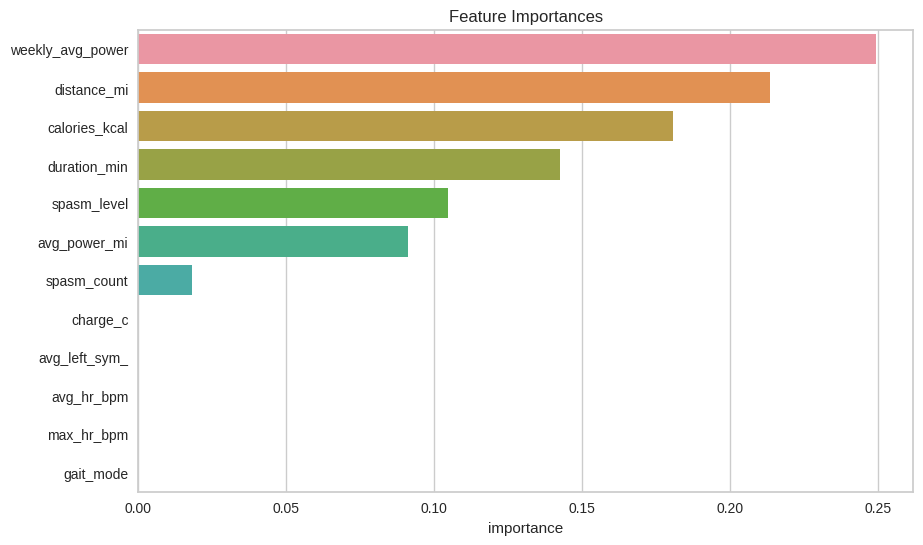

In [108]:
# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances')
plt.show()

In [109]:
a = longevity_summary_df_v1[longevity_summary_df_v1.high_consistency == True]
print(a.shape)
print(a.Cluster.nunique())

(6292, 29)
5


In [111]:
# Approach-3 for device-2:

summary_df_v2['date_time'] = pd.to_datetime(summary_df_v2['date_time'])
longevity_summary_df_v2 = pd.merge(summary_df_v2, longevity_metrics_v2, on='user_id')

# Engineered feature: Average power per week:
longevity_summary_df_v2['week'] = longevity_summary_df_v2['date_time'].dt.isocalendar().week
weekly_avg_power_v2 = longevity_summary_df_v2.groupby(['user_id', 'week'])['avg_power_mi'].mean().reset_index()
weekly_avg_power_v2.columns = ['user_id', 'week', 'weekly_avg_power']
longevity_summary_df_v2 = pd.merge(longevity_summary_df_v2, weekly_avg_power_v2, on=['user_id', 'week'], how='left')

# RandomForestClassfier to classify users based on their consistency:

# Create binary target for high consistency
# Assuming lower workout_consistency_sd indicates higher consistency
longevity_summary_df_v2['high_consistency'] = longevity_summary_df_v2['workout_consistency_sd'] < longevity_summary_df_v2['workout_consistency_sd'].median()

# Select features and target variable
features = ['duration_min', 'avg_power_mi', 'distance_mi', 'calories_kcal', 
            'charge_c', 'avg_left_sym_', 'avg_hr_bpm', 'max_hr_bpm', 
            'gait_mode', 'spasm_level', 'spasm_count', 'weekly_avg_power']
target = 'high_consistency'

X = longevity_summary_df_v2[features]
y = longevity_summary_df_v2[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

       False       0.94      0.98      0.96       177
        True       0.97      0.91      0.94       128

    accuracy                           0.95       305
   macro avg       0.96      0.95      0.95       305
weighted avg       0.96      0.95      0.95       305



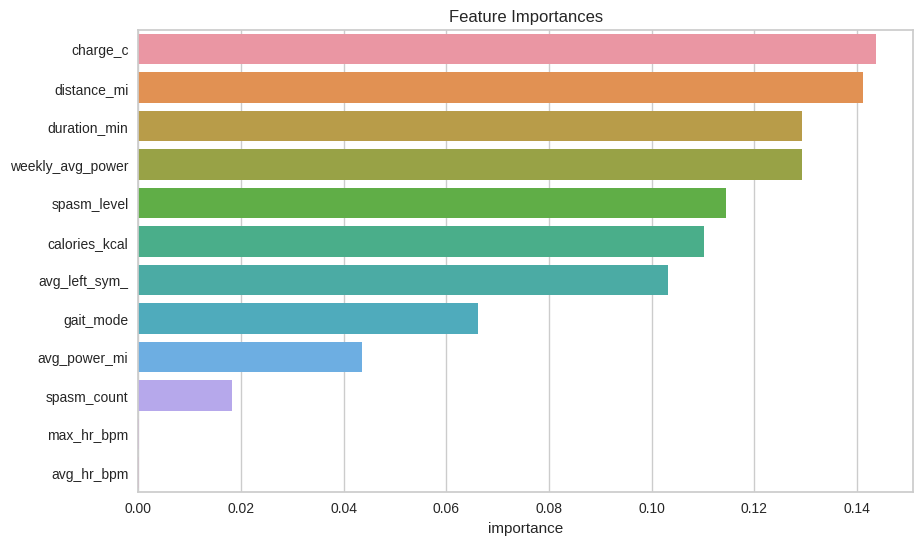

In [112]:
# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances')
plt.show()

In [113]:
a = longevity_summary_df_v2[longevity_summary_df_v2.high_consistency == True]
print(a.shape)
print(a.Cluster.nunique())

(643, 29)
3


/tmp/ipykernel_4006078/1894921502.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['high_consistency'] = filtered_df['workout_consistency_sd'] < filtered_df['workout_consistency_sd'].median()


              precision    recall  f1-score   support

       False       0.97      0.98      0.98       812
        True       0.98      0.97      0.97       672

    accuracy                           0.98      1484
   macro avg       0.98      0.98      0.98      1484
weighted avg       0.98      0.98      0.98      1484



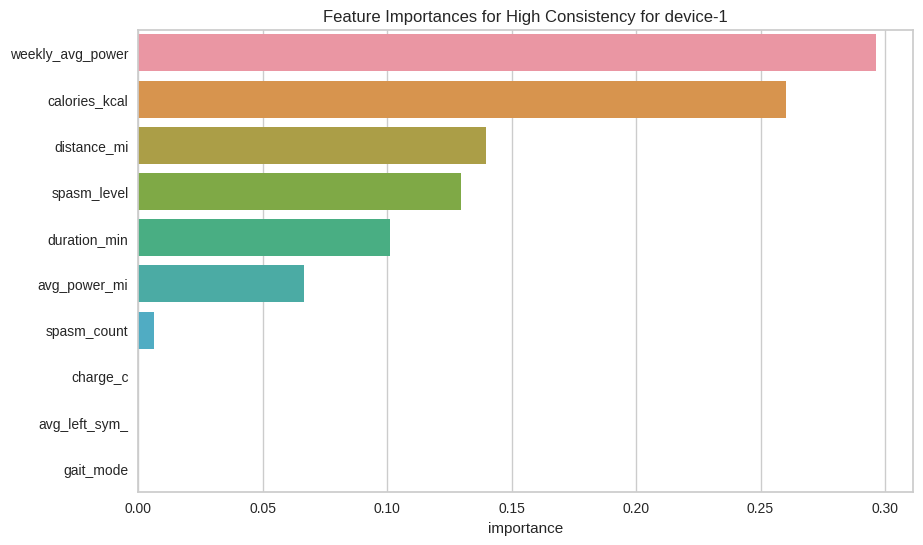

In [114]:
# Approach-4 for device-1: Analyze Clusters 0 and 4 and do EDA to identify noticeable patterns
# Why analyze 4 and 0: cuz it has the lowest standard deviation for workout consistency -> these are users with regular workouts

clusters_to_analyze = [4, 0]
filtered_df = longevity_summary_df_v1[longevity_summary_df_v1['Cluster'].isin(clusters_to_analyze)]

# Create a binary target for high consistency
filtered_df['high_consistency'] = filtered_df['workout_consistency_sd'] < filtered_df['workout_consistency_sd'].median()

# Select features and target variable
features = ['duration_min', 'avg_power_mi', 'distance_mi', 'calories_kcal', 
            'charge_c', 'avg_left_sym_', 'gait_mode', 'spasm_level', 'spasm_count', 'weekly_avg_power']
target = 'high_consistency'

X = filtered_df[features]
y = filtered_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances for High Consistency for device-1')
plt.show()


/tmp/ipykernel_4006078/3159781987.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_v2['high_consistency'] = filtered_df_v2['workout_consistency_sd'] < filtered_df_v2['workout_consistency_sd'].median()


              precision    recall  f1-score   support

       False       0.99      0.99      0.99        92
        True       0.86      0.86      0.86         7

    accuracy                           0.98        99
   macro avg       0.92      0.92      0.92        99
weighted avg       0.98      0.98      0.98        99



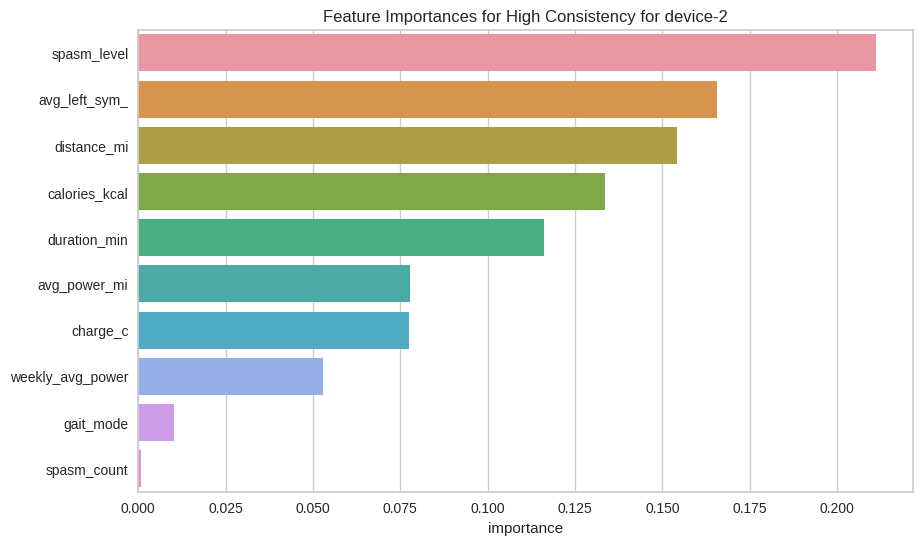

In [115]:
# Approach-4 for device-2: Analyze Clusters 2 and 6 and do EDA to identify noticeable patterns
# Why analyze 2 and 6: cuz it has the lowest standard deviation for workout consistency -> these are users with regular workouts

clusters_to_analyze = [2, 6]
filtered_df_v2 = longevity_summary_df_v2[longevity_summary_df_v2['Cluster'].isin(clusters_to_analyze)]

# Create a binary target for high consistency
filtered_df_v2['high_consistency'] = filtered_df_v2['workout_consistency_sd'] < filtered_df_v2['workout_consistency_sd'].median()

# Select features and target variable
features = ['duration_min', 'avg_power_mi', 'distance_mi', 'calories_kcal', 
            'charge_c', 'avg_left_sym_', 'gait_mode', 'spasm_level', 'spasm_count', 'weekly_avg_power']
target = 'high_consistency'

X = filtered_df_v2[features]
y = filtered_df_v2[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances for High Consistency for device-2')
plt.show()
